In [ ]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import chi2
import statsmodels as sm
import statsmodels.api as smapi
from scipy.spatial import distance
import scipy.optimize as so
from random import seed
from random import random
seed(23)

%matplotlib inline

In [3]:
# Pull Data
data_0 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet0')
data_1 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet1')
data_2 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet2')
data_3 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet3')

# Column labels
column_names = ['obs','Y','D','X1','X2','Z1','Z2']
data_0.columns = column_names
data_1.columns = column_names
data_2.columns = column_names
data_3.columns = column_names


DataSet 0:

Part A: Probit Regression
Optimization terminated successfully.
         Current function value: 0.588268
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      D   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:                 0.09027
Time:                        12:45:14   Log-Likelihood:                -5882.7
converged:                       True   LL-Null:                       -6466.4
Covariance Type:            nonrobust   LLR p-value:                8.683e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.2879      0.013     21.572      0.000       0.262   

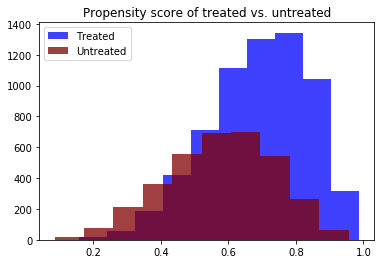

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [5]:
# DataSets 0, 1, 3 are alright...DataSet2 takes a while!
database_list = [data_0]
re_match = "yes"
count=0

for data in database_list:
    print('')
    print('DataSet ' + str(count) + ':')
    # Prepare data
    w = data[['X1','X2','Z1','Z2']]
    y = data[['D']]
    
    # Part A
    print('')
    print('Part A: Probit Regression')
    
    # Run probit model and print results
    model = sm.discrete.discrete_model.Probit(y, w)
    results = model.fit()
    print(results.summary())
    
    
    ###plot p-scores for two groups
    print('')
    print('Part B: Histogram')
    
    data['p_score'] = results.predict() #calculate fitted values
    
    fig, ax = plt.subplots()
    plt.hist(data[(data['D']==1)]['p_score'],label='Treated',alpha=0.75, color = "blue")
    plt.hist(data[(data['D']==0)]['p_score'],label='Untreated',alpha=0.75, color = "maroon")
    ax.set_title('Propensity score of treated vs. untreated')
    ax.legend(loc='best')
    plt.savefig('Problem Set 4 Charts/3C DataSet' + str(count) + ' hist.png')
    plt.show()
    
    count = count + 1
    
    # This option allows old runs of matching to be used (i.e. for DataSet2)
    if re_match=="yes":
        ###match and calculate observation TEs
        #calculate covariance matrix inverse for distance (makes code faster)
        Σ = np.cov(np.array(data[['X1','X2','Z1','Z2']]).transpose())
        Σ_inv = np.linalg.inv(Σ)
        data['TE'] = np.nan
        σ_x1, σ_x2, σ_z1, σ_z2 = Σ[0,0]**0.5, Σ[1,1]**0.5, Σ[2,2]**0.5, Σ[3,3]**0.5

        #convert panda to array to speed up loop
        V_1 = data[data['D'] == 1]
        V_1 = np.array(V_1[['X1','X2','Z1','Z2']])
        V_0 = data[data['D'] == 0]
        V_0 = np.array(V_0[['X1','X2','Z1','Z2']])
        V = np.array(data[['X1','X2','Z1','Z2']])
        D = np.array(data[['D']])
        factor = 0.5

        for i in range(len(data)):
            
            # Tracker while running
            if i%1000==0:
                print(str(i))

            #extract element
            v_1 = V[i]#np.array(data[['X1','X2','Z1','Z2']].iloc[i])
            d_id = D[i][0]

            # Only search over opposite Treated vs. Untreated
            '''This step is a quick heuristic to cut down on the
            search time. We essentially use a simpler proxy for the
            whole Mahalanobis metric to rule out obs which will probably 
            not match'''
            if d_id == 1:
                V_compare = [v for v in V_0 if abs(v[0]-v_1[0])/σ_x1<factor and abs(v[1]-v_1[1])/σ_x2<factor and abs(v[2]-v_1[2])/σ_z1<factor and abs(v[3]-v_1[3])/σ_z2<factor]
            else:
                V_compare = [v for v in V_1 if abs(v[0]-v_1[0])/σ_x1<factor and abs(v[1]-v_1[1])/σ_x2<factor and abs(v[2]-v_1[2])/σ_z1<factor and abs(v[3]-v_1[3])/σ_z2<factor]

            #look for nearest neighbour
            current_best = 99999999
            nn_loc = 0

            # Search over the respective set
            for v_2 in V_compare:
                if distance.mahalanobis(v_1, v_2, Σ_inv)<current_best and np.where(V == v_2)[0][0]!=i:
                    nn_loc = np.where(V == v_2)[0][0]
                    current_best = distance.mahalanobis(v_1, v_2, Σ_inv)

            data.iloc[i, data.columns.get_loc('TE')] = (2*data.iloc[i, data.columns.get_loc('D')]-1)*(data.iloc[i, data.columns.get_loc('Y')]-data.iloc[nn_loc, data.columns.get_loc('Y')])

In [6]:
'''This is a general function which takes data, estimator type,
and a few other specifications, and returns the TE as a function
of the propensity score'''
def estimator(data, estimator = 'ATE',p_score = 'p_score',TE = 'TE', D = 'D', p_l = 0, p_u = 1, bins = 20, graph = "yes", return_values = "no"):

    # For Average Marginal TE
    if estimator == 'AMTE':
        df = data[(data[p_score]<=p_u)]
        df = df[df[p_score] >= p_l][TE]
        AMTE = np.mean(df)
        values = np.array([AMTE,AMTE])
        p_values = np.array([p_l,p_u])
        return values, p_values
    
    # Create prop score domain
    p_values = np.linspace(p_l, p_u, bins + 1)
    values = np.zeros(bins+1)
    
    # Get appropriate data subset
    if estimator == 'TOT':
        data = data[data[D]==1]
    if estimator == 'TUT':
        data = data[data[D]==0]
        
    # Get binned results
    for i in range(bins):
        p = p_values[i]
        df = data[(data[p_score]<=p + 1/(2*bins))]
        df = df[df[p_score] >= p - 1/(2*bins)][TE]
        values[i] = np.mean(df)
    
    #drop nan values
    p_values = np.delete(p_values, np.where(np.isnan(values)))
    values = np.delete(values, np.where(np.isnan(values)))
    
    # Plot
    if graph == "yes":
        fig, ax = plt.subplots()
        ax.plot(p_values, values, linewidth=2, alpha=0.6, label=estimator)
        ax.legend(loc='best')
        ax.set_title(estimator + ' vs propensity score')
        ax.set_xlabel('Propensity Score')
        plt.show()
    
    # Values
    if return_values == "yes":
        return values, p_values




DataSet0:


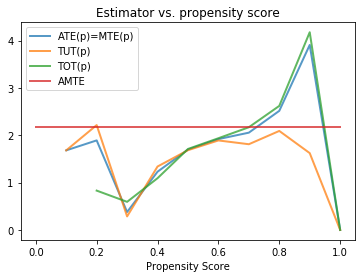

In [8]:
# Control the granularity of the TE plots
bin_size = 10

# Prop score bounds
p_l = 0
p_u = 1

count = 0
for data in database_list:
    # Get the TEs
    ATE = estimator(data, estimator = 'ATE', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    TUT = estimator(data, estimator = 'TUT', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    TOT = estimator(data, estimator = 'TOT', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    AMTE = estimator(data, estimator = 'AMTE', p_l = p_l, p_u = p_u, graph = 'no', return_values = 'yes')
    
    # Plot'em!
    print('')
    print('DataSet' + str(count) + ':')
    fig, ax = plt.subplots()
    ax.plot(ATE[1], ATE[0], linewidth=2, alpha=0.75, label='ATE(p)=MTE(p)')
    ax.plot(TUT[1], TUT[0], linewidth=2, alpha=0.75, label='TUT(p)')
    ax.plot(TOT[1], TOT[0], linewidth=2, alpha=0.75, label='TOT(p)')
    ax.plot(AMTE[1], AMTE[0], linewidth=2, alpha=0.75, label='AMTE')
    ax.legend(loc='best')
    ax.set_title('Estimator vs. propensity score')
    ax.set_xlabel('Propensity Score')
    plt.savefig('Problem Set 4 Charts/3C_DataSet' + str(count) + '_est_pscore.png')
    plt.show()
    
    # For labels
    count = count + 1


DataSet0:


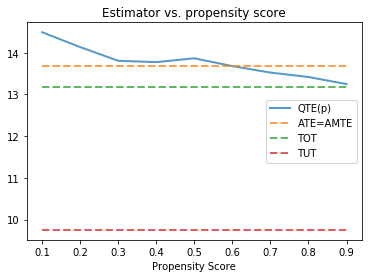

In [10]:
count = 0
for data in database_list:
    
    print('')
    print('DataSet' + str(count) + ':')
    
    # ATE regression
    X = data['p_score']
    X = smapi.add_constant(X)
    y = data['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    #print(results.summary())
    ATE_est = results.params[1]
    
    #Quantile Regression Estimates
    q_l = 0.1
    q_u = 0.9
    steps = 9
    model = sm.regression.quantile_regression.QuantReg(y,X)
    q_est = np.zeros(steps)
    quantile = np.linspace(q_l, q_u, steps)
    for i in range(len(q_est)):
        results = model.fit(q = quantile[i])
        q_est[i] = results.params[1]

    # TUT reg
    df = data[(data['D'] == 0)]
    X = df['p_score']
    X = smapi.add_constant(X)
    y = df['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    #print(results.summary())
    TUT_est = results.params[1]

    # TOT reg
    df = data[(data['D'] == 1)]
    X = df['p_score']
    X = smapi.add_constant(X)
    y = df['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    #print(results.summary())
    TOT_est = results.params[1]


    # Plot for quantile reg
    fig, ax = plt.subplots()
    ax.plot(quantile, q_est, linewidth=2, alpha=0.75, label='QTE(p)')
    ax.plot(np.array([q_l,q_u]), np.array([ATE_est,ATE_est]), linewidth=2, linestyle = "dashed", alpha=0.75, label='ATE=AMTE')
    ax.plot(np.array([q_l,q_u]), np.array([TOT_est,TOT_est]), linewidth=2, linestyle = "dashed", alpha=0.75, label='TOT')
    ax.plot(np.array([q_l,q_u]), np.array([TUT_est,TUT_est]), linewidth=2, linestyle = "dashed", alpha=0.75, label='TUT')
    ax.legend(loc='best')
    ax.set_title('Estimator vs. propensity score')
    ax.set_xlabel('Propensity Score')
    plt.savefig('Problem Set 4 Charts/3D_DataSet' + str(count) + '_qreg_plot.png')
    plt.show()
    
    count = count + 1


DataSet0:


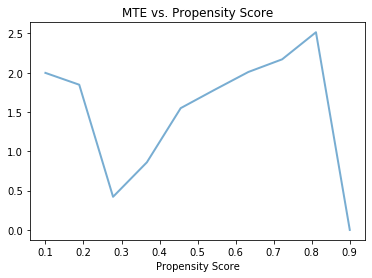

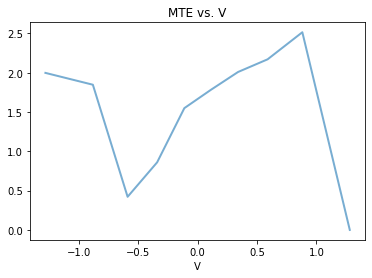

In [11]:
bin_no = 9
p_l = 0.1
p_u = 0.9

count = 0
for data in database_list:
    
    print('')
    print('DataSet' + str(count) + ':')
    
    # First we do the "standard" MTE(u)
    MTE = estimator(data, estimator = 'ATE', p_l = 0.1, p_u = 0.9, bins = bin_no, graph = 'no', return_values = 'yes')
    fig, ax = plt.subplots()
    ax.plot(MTE[1], MTE[0], linewidth=2, alpha=0.6, label='MTE(p)')
    ax.set_title('MTE vs. Propensity Score')
    ax.set_xlabel('Propensity Score')
    plt.savefig('Problem Set 4 Charts/3F_DataSet' + str(count) + '_MTE(U_D)_plot.png')
    plt.show()
    
    # We use Phi^{-1}*u = v, if we normalize sigma_V = 1
    MTE_x_2 = [norm.ppf(p) for p in MTE[1]]
    fig, ax = plt.subplots()
    ax.plot(MTE_x_2, MTE[0], linewidth=2, alpha=0.6, label='MTE(V)')
    ax.set_title('MTE vs. V')
    ax.set_xlabel('V')
    plt.savefig('Problem Set 4 Charts/3F_DataSet' + str(count) + '_MTE(V)_plot.png')
    plt.show()
    
    count = count + 1


DataSet0:
Regression on treated
                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                          1.756e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        13:19:48   Log-Likelihood:                         -16229.
No. Observations:                6513   AIC:                                  3.246e+04
Df Residuals:                    6510   BIC:                                  3.248e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/Users/chaseabram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/Users/chaseabram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


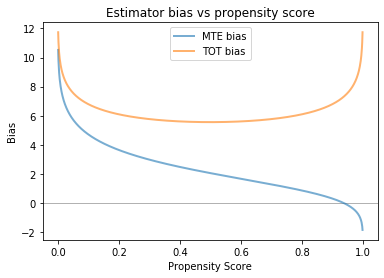

In [13]:
count = 0

for data in database_list:
    
    print('')
    print('DataSet' + str(count) + ':')
    
    #create bias regression variable
    df = data
    df['cntr_f_v_1'] = norm.pdf(norm.ppf(df['p_score']))/df['p_score']
    df['cntr_f_v_0'] = norm.pdf(norm.ppf(df['p_score']))/(1-df['p_score'])
    
    #Regression on treated
    print('Regression on treated')
    df_1 = df[df['D']==1]
    X = df_1[['X1','X2','cntr_f_v_1']]
    #X = smapi.add_constant(X) (reminder to not add the constant)
    y = df_1['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    print(results.summary())
    β_11, β_12, ζ_1 = results.params

    #Regression on untreated
    print('Regression on untreated')
    df_0 = df[df['D']==0]
    X = df_0[['X1','X2','cntr_f_v_0']]
    #X = smapi.add_constant(X) (reminder to not add the constant)
    y = df_0['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    print(results.summary())
    β_01, β_02, ζ_0 = results.params
    
    #add estimates to dataframe to evaluate parameters of interest
    df['β_11'] = β_11
    df['β_12'] = β_12
    df['ζ_1'] = ζ_1
    df['β_01'] = β_01
    df['β_02'] = β_02
    df['ζ_0'] = ζ_0
          
    #evaluate parameter value at each point,
    df['ATE'] = df['β_11']*df['X1'] + df['β_12']*df['X2'] - df['β_01']*df['X1'] - df['β_02']*df['X2']
    df['MTE'] = df['β_11']*df['X1'] + df['β_12']*df['X2'] - df['β_01']*df['X1'] - df['β_02']*df['X2'] - (df['ζ_1'] + df['ζ_0'])*norm.ppf(df['p_score'])
    df['TOT'] = df['β_11']*df['X1'] + df['β_12']*df['X2'] - df['β_01']*df['X1'] - df['β_02']*df['X2'] + (df['ζ_1'] + df['ζ_0'])*df['cntr_f_v_1']
    count = count + 1
    
    p_values = np.linspace(0, 1, 1000)
    #Bias expressions from NBER working paper appendix by Heckman and Navarro-Lozano
    MTE_bias = [(ζ_0*p + ζ_1*(1-p))*norm.pdf(norm.ppf(1-p))/(p*(1-p)) - norm.ppf(1-p)*(ζ_1 - ζ_0) for p in p_values]
    TOT_bias = [ζ_0*norm.pdf(norm.ppf(1-p))/(p*(1-p)) for p in p_values]
    
    # Plot
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='gray',alpha=0.6, linewidth=1)
    ax.plot(p_values, MTE_bias, linewidth=2, alpha=0.6, label='MTE bias')
    ax.plot(p_values, TOT_bias, linewidth=2, alpha=0.6, label='TOT bias')
    ax.legend(loc='best')
    ax.set_title('Estimator bias vs propensity score')
    ax.set_xlabel('Propensity Score')
    ax.set_ylabel('Bias')
    plt.savefig('Problem Set 4 Charts/5C_DataSet' + str(count) + '_bias_plot.png')
    plt.show()

Optimization terminated successfully.
         Current function value: 0.588268
         Iterations 5
0.04362345955896896


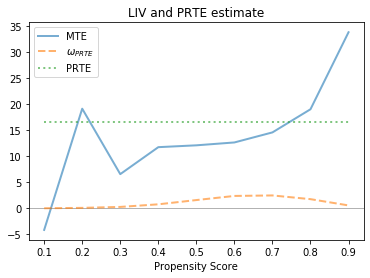

In [14]:
count = 0

for data in database_list:
    
    points = 11
    p_values = np.linspace(0, 1, points)
    
    #Find E[Y|P(X,P)=p]
    expected_value = np.zeros(len(p_values))
    
    # mean within bins
    for i in range(len(p_values)):
        p = p_values[i]
        df = data[data['p_score']<=p + 1/(2*points)]
        df = df[df['p_score'] >= p - 1/(2*points)]['Y']
        expected_value[i] = np.mean(df)

    #drop NaN values
    p_values = np.delete(p_values, np.where(np.isnan(expected_value)))
    expected_value = np.delete(expected_value, np.where(np.isnan(expected_value)))
    
    #Calculate LIV
    LIV = np.empty(len(p_values))
    LIV[:] = np.NaN
    
    # Slope calculation (discrete derivative)
    for i in range(len(p_values)-1):
        LIV[i] = (expected_value[i+1] - expected_value[i])/(p_values[i+1]-p_values[i])
        
    #drop nan values
    p_values = np.delete(p_values, np.where(np.isnan(LIV)))
    LIV = np.delete(LIV, np.where(np.isnan(LIV)))
    
    # new policy: 10% decrease in each covariate of Z
    '''The idea is that we can use the same MTE, since all TE
    are just a weighting of MTE. So we just need the weights.'''
    
    # generate counterfactual Z
    df = data
    df['Z1_new'] = df['Z1']*0.9
    df['Z2_new'] = df['Z2']*0.9
    
    ###prepare data
    w = data[['X1','X2','Z1','Z2']]
    w_new = data[['X1','X2','Z1_new','Z2_new']]
    y = data[['D']]
    
    ###run probit model and print results
    model = sm.discrete.discrete_model.Probit(y, w)
    results = model.fit()
    p_score_new =  np.array(results.predict(w_new))
    p_score = np.array(df['p_score'])
    
    #define cdf for p_scores
    F_p = lambda u : len([p for p in p_score if p <= u])/len(p_score)
    F_p_new = lambda u : len([p for p in p_score_new if p <= u])/len(p_score_new)

    #calculate expectation difference between the two p
    exp_d = np.mean(p_score_new) - np.mean(p_score)
    print(exp_d)
    #calculate PRTE weight (from lecture slides and previous pset)
    ω_PRTE = [F_p(u) - F_p_new(u) for u in p_values]/(exp_d)
    PRTE = np.dot(LIV,ω_PRTE)/len(LIV)

    # Plot
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='gray',alpha=0.6, linewidth=1)
    ax.plot(p_values, LIV, linewidth=2, alpha=0.6, label='MTE')
    ax.plot(p_values, ω_PRTE, linewidth=2, alpha=0.6, linestyle = 'dashed', label='$\omega_{PRTE}$')
    ax.plot([p_values[0],p_values[-1]], [PRTE,PRTE], linewidth=2, linestyle = 'dotted', alpha=0.6, label='PRTE')
    ax.set_title('LIV and PRTE estimate')
    ax.set_xlabel('Propensity Score')
    ax.legend(loc='best')
    plt.savefig('Problem Set 4 Charts/5C_DataSet' + str(count) + '_LIV_plot.png')
    plt.show()
    
    count = count + 1



In [24]:
data['X1'][0]

2.141140539996573

In [ ]:
'''This parameter is a normalization
which helps prevent the optimization routine
from hitting divide by zero of log(0) errors
due to numerical approximation.'''
scale = 1000

caller = 0

'''Given data, this function computes the
NEGATIVE of the log-likelihood. The negative is so that we may
use the standard minimization routine for maximization.
params = beta_11, beta_12, beta_01, beta_02, gamma_1, gamma_2'''
def royll(params,Y,D,X1,X2,Z1,Z2, caller = caller):
    # Keep track of log-likelihood added/subtracted by each observation
    llsum = 0
    
    for i in range(0,len(Y)):
#         if i % 1000 == 0:
#             print("i = ", i)
#             print("Y: ", Y[i])
#             print("D: ", D[i])
#             print("X1: ", X[1][i])
#             print("Z1: ", Z[1][i])
#             print("X2: ", X[2][i])
#             print("Z2: ", Z[2][i])
#             print("i: ", i)
#             print(D[i]*np.log(norm.pdf((Y[i] - X[0][i]*params[0] - X[1][i]*params[1])/params[6])))
#             llsum += 1
            
#             print("first in: ", norm.pdf((Y[i] - X[1][i]*params[0] - X[2][i]*params[1])/50)* \
#                             norm.cdf((Y[i] - X[1][i]*params[2] - X[2][i]*params[3] \
#                                       - Z[1][i]*params[4] - Z[2][i]*params[5])/50))
#             print("first in in: ", norm.pdf((Y[i] - X[1][i]*params[0] - X[2][i]*params[1])/50))
            
#             print("second in: ", )
#             print("D = 1: ", )
#             print("D = 0: ", )
            
        llsum += D[i]*np.log(norm.pdf((Y[i] - X1[i]*params[0] - X2[i]*params[1])/scale)* \
                            norm.cdf((Y[i] - X1[i]*params[2] - X2[i]*params[3] \
                                      - Z1[i]*params[4] - Z2[i]*params[5])/scale)) \
            + (1 - D[i])*np.log(norm.pdf((Y[i] - X1[i]*params[2] - X2[i]*params[3])/scale)* \
                            (1 - norm.cdf((-Y[i] + X1[i]*params[0] + X2[i]*params[1] \
                                      - Z1[i]*params[4] - Z2[i]*params[5])/scale)))
        
    return -1/len(Y)*llsum

# royll([8,1,2,3,4,5,6,7,8,9],[1,1],[2,2],[[3,3],[4,4]],[[5,5],[6,6]])
# x = [[1,2],[3,4]]
# print(np.shape(x))
# print(x[1][1])
# so.minimize(royll, [5,14],args = ([9],5,5,5))

for data in database_list:
    output = so.minimize(royll, [11,-10,5,7,90,-100],args = (data['Y'], data['D'], 
                                                    data['X1'], data['X2'], 
                                                    data['Z1'], data['Z2']), 
                method = 'Nelder-Mead', options={'disp': True, 'adaptive': True})
    print(output)

# Need to use OLS for initial guess?
# Use bootstrap for standard errors

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
14.00987967,  -42.14385235, -383.63489416,  -84.73230876,
        -56.45827662,  395.23783503 (1000)
    
 3.02307192,  -3.40777563, -37.08774057,  -8.35250139,
        -5.01160652,  39.28636718 